In [1]:
from osgeo import gdal, osr
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
import geopandas as gpd
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import seaborn as sns
import fiona

import sys
sys.path.append('/Users/allen/Documents/Python/geoPackage')
sys.path.append('/Users/allen/Documents/Python/Plotgallary')
from geoPackage.io import ReadFile
from geoPackage.raster import Geoprocess
from matplotlibconfig import basic

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  if sys.path[0] == '':


In [2]:
basic()

### Read rmse data

In [3]:
gauge_rmse= '../TCresults/rmse_gauge.tif'
satellite_rmse= '../TCresults/rmse_sat.tif'
radar_rmse= '../TCresults/rmse_radar.tif'

gauge_rmse_Harvey= '../TCresults/TCresultsHarvey/rmse_gauge_mtc.tif'
satellite_rmse_Harvey= '../TCresults/TCresultsHarvey/rmse_sat_mtc.tif'
radar_rmse_Harvey= '../TCresults/TCresultsHarvey/rmse_radar_mtc.tif'

gauge_rmse_nonHarvey= '../TCresults/TCresults_nonHarvey/rmse_gauge.tif'
satellite_rmse_nonHarvey= '../TCresults/TCresults_nonHarvey/rmse_sat.tif'
radar_rmse_nonHarvey= '../TCresults/TCresults_nonHarvey/rmse_radar.tif'

### Read CC data

In [4]:
gauge_cc= '../TCresults/cc_gauge.tif'
satellite_cc= '../TCresults/cc_sat.tif'
radar_cc= '../TCresults/cc_radar.tif'

gauge_cc_Harvey= '../TCresults/TCresultsHarvey/cc_gauge_mtc.tif'
satellite_cc_Harvey= '../TCresults/TCresultsHarvey/cc_sat_mtc.tif'
radar_cc_Harvey= '../TCresults/TCresultsHarvey/cc_radar_mtc.tif'

gauge_cc_nonHarvey= '../TCresults/TCresults_nonHarvey/cc_gauge.tif'
satellite_cc_nonHarvey= '../TCresults/TCresults_nonHarvey/cc_sat.tif'
radar_cc_nonHarvey= '../TCresults/TCresults_nonHarvey/cc_radar.tif'

In [5]:
harveyimpact= '../../harveyimpact/harveyimpact.shp'
restricted= '../shp/restricted.shp'
NCEP_pnts= '../../NCEP_gauge_locations.shp'

In [4]:
def mask_raster(raster_name, shapes_name, crop=False):
    raster= rasterio.open(raster_name)
    with fiona.open(shapes_name, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    
    out_img, out_transform = mask(raster, shapes, crop=False, nodata=np.nan)
    
    return out_img.squeeze()

In [67]:
def plot(src, **kwargs):
    # Plotting 2070 projected August (8) precip from worldclim
    gdata = gdal.Open(src)
    geo = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(float)
    xres = geo[1]
    yres = geo[5]
    data= mask_raster(src, restricted)
    data[(data<0)]= np.nan
    avg= np.nanmean(data)
    mx= np.nanmax(data)
    mn= np.nanmin(data)

    # A good LCC projection for USA plots
    m = Basemap(llcrnrlon=-98,llcrnrlat=27.5,urcrnrlon=-91.5,urcrnrlat=32.8,
                projection='cyl',lat_1=33,lat_2=45,lon_0=-95)

    # This just plots the shapefile -- it has already been clipped
    m.readshapefile('../../harveyimpact/harveyimpact','harveyimpact',drawbounds=True, linewidth=2)
#     m.readshapefile('../harveyimpact/400mmzone','rain',drawbounds=True, color='0.2')
#     m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-90, 90, 2), labels=[True,False,True,False],  linewidth=.2)
    m.drawmeridians(np.arange(-180, 180, 2), labels=[True,False,True,False], linewidth=.2)
#     m.drawmapboundary(fill_color='white', linewidth=0)

    xmin = geo[0] + xres * 0.5
    xmax = geo[0] + (xres * gdata.RasterXSize) - xres * 0.5
    ymin = geo[3] + (yres * gdata.RasterYSize) + yres * 0.5
    ymax = geo[3] - yres * 0.5

    x,y = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    x,y = m(x,y)
    cmap= kwargs.get('cmap', None)
    if cmap is None:
        cmap = plt.get_cmap('jet')
#         cmap.set_under ('1.0')
        cmap.set_bad('1')

    map = m.pcolormesh(x,y, data.T, cmap=cmap, **kwargs)

#     cb = plt.colorbar( orientation='vertical', fraction=0.10, shrink=0.7)
    data= data[~np.isnan(data)].reshape(-1,1)
    return map, avg, mn, mx, data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


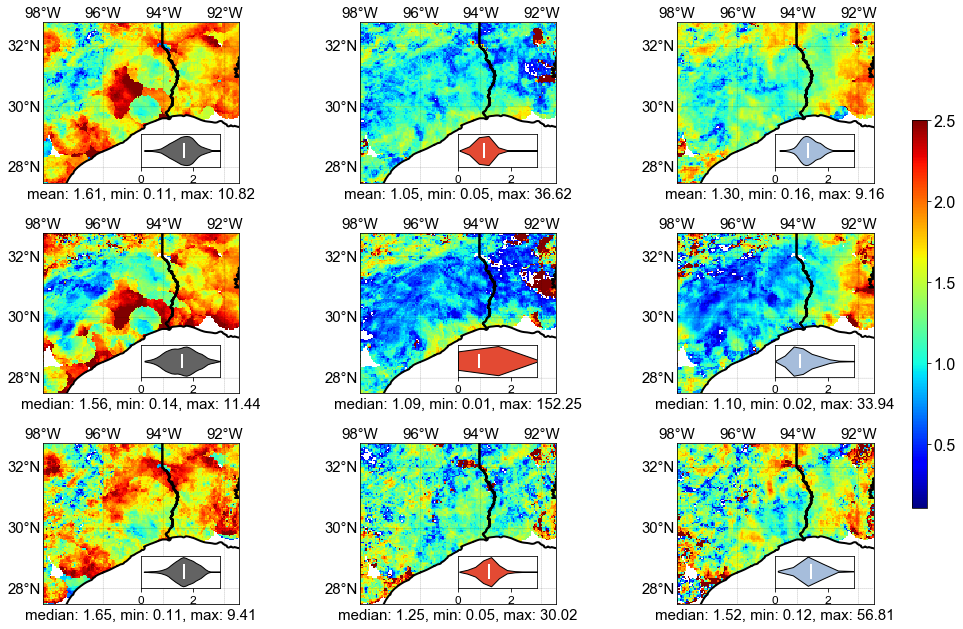

In [68]:
fig= plt.figure(figsize=(14, 9))

ax = fig.add_subplot(3,3,1)
# ax.set_title("NCEP")
map, avg, mn, mx, data = plot(gauge_rmse, vmin=0, vmax=2.5)
# ax.set_ylabel('All')
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#636363')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    
    

violin['cmedians'].set_edgecolor('white')

# inset_ax.set_xlim([0, 5])
# inset_ax.set_ylim([0.75, 1.25])

ax = fig.add_subplot(3,3,2)
# ax.set_title("MRMS")
map, avg, mn, mx, data=plot(radar_rmse, vmin=0, vmax=2.5)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#e34a33')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,3)
# ax.set_title("IMERG")
map, avg, mn, mx, data = plot(satellite_rmse, vmin=0, vmax=2.5)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('gauge',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#a6bddb')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,4)
map, avg, mn, mx, data = plot(gauge_rmse_Harvey, vmin=0, vmax=2.5)
# ax.set_ylabel('Harvey')
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0, 3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#636363')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,5)

map, avg, mn, mx, data = plot(radar_rmse_Harvey, vmin=0, vmax=2.5)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('TC',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#e34a33')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,6)

map, avg, mn, mx, data = plot(satellite_rmse_Harvey, vmin=0, vmax=2.5)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('radar',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#a6bddb')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,7)
# ax.set_ylabel('non Harvey')
map, avg, mn, mx, data = plot(gauge_rmse_nonHarvey, vmin=0, vmax=2.5)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#636363')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,8)

map, avg, mn, mx, data = plot(radar_rmse_nonHarvey, vmin=0, vmax=2.5)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('satellite',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#e34a33')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,9)

map, avg, mn, mx, data = plot(satellite_rmse_nonHarvey, vmin=0.1, vmax=2.5)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)

# ax.set_ylabel('TC',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,3])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#a6bddb')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

cbar= fig.add_axes((0.95,0.2,.015,.6))
cb = plt.colorbar( orientation='vertical', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)
# cb.set_label('mm/hour', rotation=270)

plt.tight_layout()
plt.show()
# fig.savefig('../graphs/rmse_comparison2.png', dpi=300)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


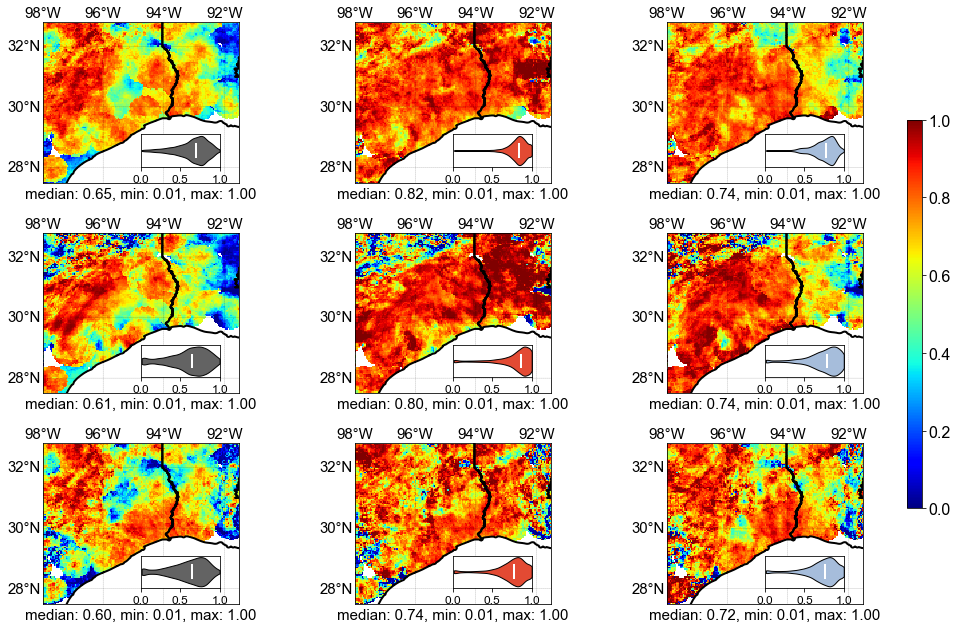

In [69]:
fig= plt.figure(figsize=(14, 9))

ax = fig.add_subplot(3,3,1)
# ax.set_title("gauge",fontsize=20)
map, avg, mn, mx, data = plot(gauge_cc, vmin=0, vmax=1)
# ax.set_ylabel('All events',fontsize=20)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#636363')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
violin['cmedians'].set_edgecolor('white')

# inset_ax.set_xlim([0, 5])
# inset_ax.set_ylim([0.75, 1.25])

ax = fig.add_subplot(3,3,2)
# ax.set_title("radar",fontsize=20)
map, avg, mn, mx, data=plot(radar_cc, vmin=0, vmax=1)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#e34a33')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,3)
# ax.set_title("satellite",fontsize=20)
map, avg, mn, mx, data = plot(satellite_cc, vmin=0, vmax=1)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('gauge',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#a6bddb')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,4)
map, avg, mn, mx, data = plot(gauge_cc_Harvey, vmin=0, vmax=1)
# ax.set_ylabel('Harvey',fontsize=20)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#636363')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,5)

map, avg, mn, mx, data = plot(radar_cc_Harvey, vmin=0, vmax=1)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('TC',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#e34a33')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,6)

map, avg, mn, mx, data = plot(satellite_cc_Harvey, vmin=0, vmax=1)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('radar',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#a6bddb')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,7)
# ax.set_ylabel('non Harvey',fontsize=20)
map, avg, mn, mx, data = plot(gauge_cc_nonHarvey, vmin=0, vmax=1)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#636363')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,8)

map, avg, mn, mx, data = plot(radar_cc_nonHarvey, vmin=0, vmax=1)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
# ax.set_ylabel('satellite',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#e34a33')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

ax = fig.add_subplot(3,3,9)

map, avg, mn, mx, data = plot(satellite_cc_nonHarvey, vmin=0, vmax=1)
ax.set_xlabel('median: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)

# ax.set_ylabel('TC',fontsize=20)
inset_ax = ax.inset_axes([0.5,0.1,0.4,0.2]) # center, you can check the different codes in plt.legend?
violin= inset_ax.violinplot(data, vert=False, showextrema=False,showmedians=True)
# higherBound= np.percentile(data, 95)
inset_ax.set_yticks([])
inset_ax.set_xlim([0,1])
inset_ax.tick_params(axis="x", labelsize=12)
for pc in violin['bodies']:
    pc.set_facecolor('#a6bddb')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
inset_ax.set_yticks([])
violin['cmedians'].set_edgecolor('white')

cbar= fig.add_axes((0.95,0.2,.015,.6))
cb = plt.colorbar( orientation='vertical', mappable= map, cax=cbar, fraction=0.70, shrink=0.7)

plt.tight_layout()
plt.show()
# fig.savefig('cc_comparison.png', dpi=300)

### Total amount

In [26]:
gauge_sum_pth= '../intercomparison/all/gauge_radar_sum_gauge.tif'
radar_sum_pth= '../intercomparison/all/gauge_radar_sum_radar.tif'
sat_sum_pth= '../intercomparison/all/gauge_satellite_sum_satellite.tif'

gauge_sum_Harvey= '../intercomparison/Harvey/gauge_satellite_sum_gauge.tif'
radar_sum_Harvey= '../intercomparison/Harvey/satellite_radar_sum_radar.tif'
sat_sum_Harvey= '../intercomparison/Harvey/gauge_satellite_sum_satellite.tif'

gauge_sum_nonHarvey= '../intercomparison/nonHarvey/gauge_radar_sum_gauge.tif'
radar_sum_nonHarvey= '../intercomparison/nonHarvey/gauge_radar_sum_radar.tif'
sat_sum_nonHarvey= '../intercomparison/nonHarvey/gauge_satellite_sum_satellite.tif'

In [11]:
cmap_data= ['#DBDAD8',"lightblue","blue", "green",
                        "greenyellow", "yellow","gold","orange", "darkorange",
                        "red", "darkred", "purple"]

def plot_amt(src, **kwargs):

    gdata = gdal.Open(src)
    geo = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(float)
    xres = geo[1]
    yres = geo[5]
    data[(data<=0.1)]= np.nan
    data= mask_raster(src, harveyimpact)
    avg= np.nanmean(data)
    mx= np.nanmax(data)
    mn= np.nanmin(data)

    # A good LCC projection for USA plots
    m = Basemap(llcrnrlon=-98,llcrnrlat=27.5,urcrnrlon=-91.5,urcrnrlat=32.8,
                projection='cyl',lat_1=33,lat_2=45,lon_0=-95,ellps = 'WGS84')

    # This just plots the shapefile -- it has already been clipped
    m.readshapefile('../../harveyimpact/harveyimpact','harveyimpact',drawbounds=True, color='0.3')
    m.readshapefile('../../harveyimpact/400mmzone','rain',drawbounds=True, color='0.2')
    m.drawparallels(np.arange(-90, 90, 2), labels=[True,False,True,False],  linewidth=.2)
    m.drawmeridians(np.arange(-180, 180, 2), labels=[True,False,True,False], linewidth=.2)
#     m.drawparallels(parallels,labels=[False,True,True,False])
    xmin = geo[0] + xres * 0.5
    xmax = geo[0] + (xres * gdata.RasterXSize) - xres * 0.5
    ymin = geo[3] + (yres * gdata.RasterYSize) + yres * 0.5
    ymax = geo[3] - yres * 0.5

    x,y = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    x,y = m(x,y)
    parallels = np.arange(-100,-90,5.)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,True,True,True])
    meridians = np.arange(30.,34.,2.)
    m.drawmeridians(meridians,labels=[True,True,True,True])
#     cmap = plt.get_cmap(cmap)
#     cmap.set_under ('1.0')
#     cmap.set_bad('0.8')
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    map = m.pcolormesh(x,y, data.T, cmap=cmap, **kwargs)

#     cb = plt.colorbar( orientation='vertical', fraction=0.10, shrink=0.5)
    data= data[~np.isnan(data)].reshape(-1,1)
    
    return map, avg, mn, mx, data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


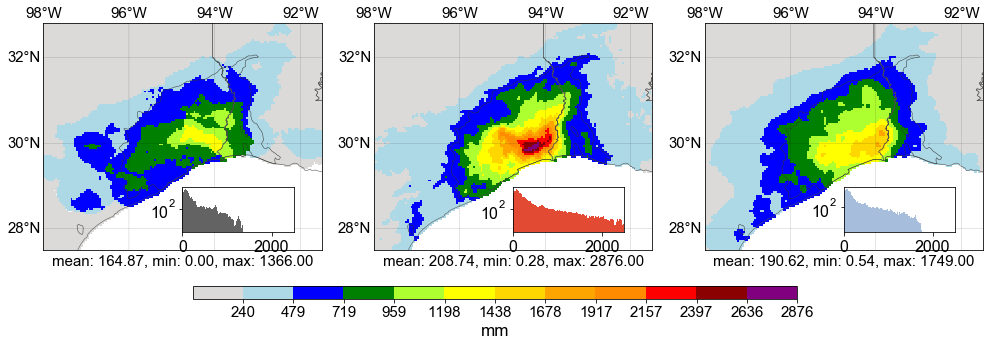

In [20]:
fig= plt.figure(figsize=(14,9))

ax = fig.add_subplot(1,3,1)
# ax.set_title("NCEP",fontsize=20)
map_1, avg, mn, mx, data = plot_amt(gauge_sum_pth, vmin=0.1, vmax=2876)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#636363', alpha=1)
# inset_ax.set_ylabel('# of samples')
# inset_ax.set_xlabel('accumulated rain (mm)')
# inset_ax.set_yticks([])
inset_ax.set_xlim([0,2500])

ax = fig.add_subplot(1,3,2)
# ax.set_title("MRMS",fontsize=20)
map_2, avg, mn_radar, mx_radar, data = plot_amt(radar_sum_pth, vmin=0.1, vmax=2876)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn_radar, mx_radar), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#e34a33', alpha=1)
inset_ax.set_xlim([0,2500])

ax = fig.add_subplot(1,3,3)
# ax.set_title("IMERG",fontsize=20)
map_3, avg, mn, mx, data = plot_amt(sat_sum_pth, vmin=0.1, vmax=2876)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#a6bddb', alpha=1)
inset_ax.set_xlim([0,2500])

cbar= fig.add_axes((0.2,0.25,.6,.02))
# cbar.ax.text(range(0.2,0.6,0.4/len(cmap_data)),.1 / 8.0, range(0,mx_radar,mx_radar/len(cmap_data)), ha='center', va='center')

# fig.tight_layout()
cbar= fig.colorbar( orientation='horizontal', mappable=map_2, cax= cbar, shrink=0.5, fraction=0.5,
                  ticks=np.linspace(0, 2876, 13))
cbar.ax.tick_params(labelsize=15)
# cbar.ax.set_ytick_labels([])
cbar.set_label('mm')
fig.tight_layout()
fig.savefig('total_all.png', dpi=300)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


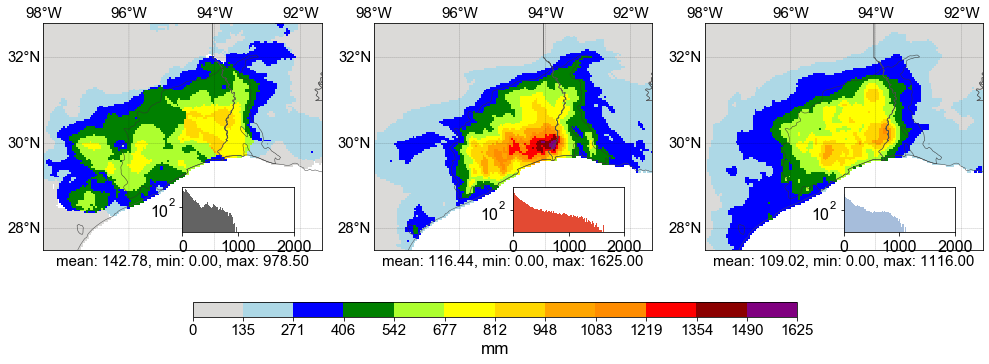

In [21]:
fig= plt.figure(figsize=(14,10))

ax = fig.add_subplot(1,3,1)
# ax.set_title("NCEP",fontsize=20)
map_1, avg, mn, mx, data = plot_amt(gauge_sum_Harvey, vmax=1625)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#636363', alpha=1)
# inset_ax.set_ylabel('# of samples')
# inset_ax.set_xlabel('accumulated rain (mm)')
# inset_ax.set_yticks([])
inset_ax.set_xlim([0,2000])

ax = fig.add_subplot(1,3,2)
# ax.set_title("MRMS",fontsize=20)
map_2, avg, mn_radar, mx_radar, data = plot_amt(radar_sum_Harvey, vmax=1625)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn_radar, mx_radar), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#e34a33', alpha=1)
inset_ax.set_xlim([0,2000])

ax = fig.add_subplot(1,3,3)
# ax.set_title("IMERG",fontsize=20)
map_3, avg, mn, mx, data = plot_amt(sat_sum_Harvey, vmax=1625)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#a6bddb', alpha=1)
inset_ax.set_xlim([0,2000])

cbar= fig.add_axes((0.2,0.25,.6,.02))
# cbar.ax.text(range(0.2,0.6,0.4/len(cmap_data)),.1 / 8.0, range(0,mx_radar,mx_radar/len(cmap_data)), ha='center', va='center')

# fig.tight_layout()
cbar= fig.colorbar( orientation='horizontal', mappable=map_2, cax= cbar, shrink=0.5, fraction=0.5,
                  ticks=np.linspace(0, 1625, 13))
cbar.ax.tick_params(labelsize=15)
# cbar.ax.set_ytick_labels([])
cbar.set_label('mm')
fig.tight_layout()

fig.savefig('total_Harvey.png', dpi=300)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


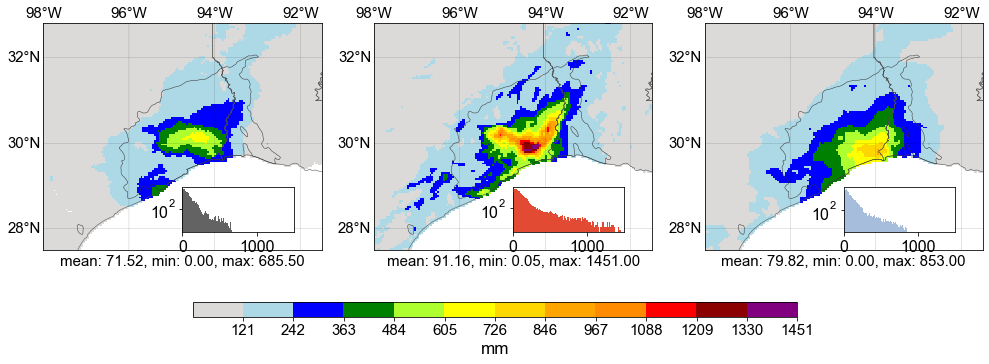

In [22]:
fig= plt.figure(figsize=(14,10))

ax = fig.add_subplot(1,3,1)
# ax.set_title("NCEP",fontsize=20)
map_1, avg, mn, mx, data = plot_amt(gauge_sum_nonHarvey, vmax=1451)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#636363', alpha=1)
# inset_ax.set_ylabel('# of samples')
# inset_ax.set_xlabel('accumulated rain (mm)')
# inset_ax.set_yticks([])
inset_ax.set_xlim([0,1500])

ax = fig.add_subplot(1,3,2)
# ax.set_title("MRMS",fontsize=20)
map_2, avg, mn_radar, mx_radar, data = plot_amt(radar_sum_nonHarvey, vmax=1451)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn_radar, mx_radar), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#e34a33', alpha=1)
inset_ax.set_xlim([0,1500])

ax = fig.add_subplot(1,3,3)
# ax.set_title("IMERG",fontsize=20)
map_3, avg, mn, mx, data = plot_amt(sat_sum_nonHarvey, vmax=1451)
ax.set_xlabel('mean: %.2f, min: %.2f, max: %.2f'%(avg, mn, mx), fontsize=15)
inset_ax = ax.inset_axes([0.5,.08,0.4,0.2]) 
inset_ax.hist(data, bins=100, log=True, color='#a6bddb', alpha=1)
inset_ax.set_xlim([0,1500])

cbar= fig.add_axes((0.2,0.25,.6,.02))
# cbar.ax.text(range(0.2,0.6,0.4/len(cmap_data)),.1 / 8.0, range(0,mx_radar,mx_radar/len(cmap_data)), ha='center', va='center')

# fig.tight_layout()
cbar= fig.colorbar( orientation='horizontal', mappable=map_2, cax= cbar, shrink=0.5, fraction=0.5,
                  ticks=np.linspace(0, 1451, 13))
cbar.ax.tick_params(labelsize=15)
# cbar.ax.set_ytick_labels([])
cbar.set_label('mm')
fig.tight_layout()

fig.savefig('total_nonHarvey.png', dpi=300)

### Conventional metrics

overall

In [60]:
gauge_satellite_rmse= '../intercomparison/all/gauge_satellite_rmse.tif'
radar_satellite_rmse= '../intercomparison/all/radar_satellite_rmse.tif'
gauge_radar_rmse= '../intercomparison/all/gauge_radar_rmse.tif'
# gauge_rmse= '../TCresults/TCresultsHarvey/rmse_gauge_mtc.tif'
# satellite_rmse= '../TCresults/TCresultsHarvey/rmse_sat_mtc.tif'
# radar_rmse= '../TCresults/TCresultsHarvey/rmse_radar_mtc.tif'


gauge_satellite_cc= '../intercomparison/all/gauge_satellite_r.tif'
radar_satellite_cc= '../intercomparison/all/radar_satellite_r.tif'
gauge_radar_cc= '../intercomparison/all/gauge_radar_r.tif'



gauge_radar_pod= '../intercomparison/all/gauge_radar_pod.tif'
gauge_radar_csi= '../intercomparison/all/gauge_radar_csi.tif'
gauge_radar_far= '../intercomparison/all/gauge_radar_far.tif'
radar_satellite_pod= '../intercomparison/all/radar_satellite_pod.tif'
radar_satellite_csi= '../intercomparison/all/radar_satellite_csi.tif'
radar_satellite_far= '../intercomparison/all/radar_satellite_far.tif'
gauge_satellite_pod= '../intercomparison/all/gauge_satellite_pod.tif'
gauge_satellite_csi= '../intercomparison/all/gauge_satellite_csi.tif'
gauge_satellite_far= '../intercomparison/all/gauge_satellite_far.tif'
gauge_sum= '../intercomparison/all/gauge_satellite_sum_gauge.tif'
radar_sum= '../intercomparison/all/radar_satellite_sum_radar.tif'
satellite_sum= '../intercomparison/all/gauge_satellite_sum_satellite.tif'

restricted= '../shp/restricted.shp'


In [31]:
def metrics(pth, shp):
#     product= gdal.Open(pth).ReadAsArray()
    product= mask_raster(pth, shp)
    product= product.reshape(-1,1)
    product= product[~np.isnan(product)]
    product= product[product>0]
#     med= np.nanmedian(product)
#     seventyFive= np.nanquantile(product, .75)
#     twentyFive= np.nanquantile(product, .25)
#     avg= np.nanmean(product)

    return product

In [34]:
names= ['RMSE', 'CC', 'POD', 'FAR', 'CSI']
for i, pth in enumerate([gauge_satellite_rmse, gauge_radar_rmse, radar_satellite_rmse,
              gauge_satellite_cc, gauge_radar_cc, radar_satellite_cc,
              gauge_satellite_pod, gauge_radar_pod, radar_satellite_pod,
              gauge_satellite_far, gauge_radar_far, radar_satellite_far,
              gauge_satellite_csi, gauge_radar_csi, radar_satellite_csi]):
    arr= metrics(pth, restricted)
    if i%3==0:
        j=i%5
        print(names[j])
    print( np.nanmean(arr))

RMSE
2.5133803
3.0759041
2.7078445
FAR
0.5225995
0.4910379
0.62375027
CC
0.6407911
0.7290449
0.6996032
CSI
0.28122574
0.2943168
0.1936432
POD
0.5217939
0.56563795
0.6044662


Other

In [62]:
gauge_satellite_rmse= '../intercomparison/nonHarvey/gauge_satellite_rmse.tif'
radar_satellite_rmse= '../intercomparison/nonHarvey/radar_satellite_rmse.tif'
gauge_radar_rmse= '../intercomparison/nonHarvey/gauge_radar_rmse.tif'
# gauge_rmse= '../TCresults/TCresultsHarvey/rmse_gauge_mtc.tif'
# satellite_rmse= '../TCresults/TCresultsHarvey/rmse_sat_mtc.tif'
# radar_rmse= '../TCresults/TCresultsHarvey/rmse_radar_mtc.tif'


gauge_satellite_cc= '../intercomparison/nonHarvey/gauge_satellite_r.tif'
radar_satellite_cc= '../intercomparison/nonHarvey/radar_satellite_r.tif'
gauge_radar_cc= '../intercomparison/nonHarvey/gauge_radar_r.tif'



gauge_radar_pod= '../intercomparison/nonHarvey/gauge_radar_pod.tif'
gauge_radar_csi= '../intercomparison/nonHarvey/gauge_radar_csi.tif'
gauge_radar_far= '../intercomparison/nonHarvey/gauge_radar_far.tif'
radar_satellite_pod= '../intercomparison/nonHarvey/radar_satellite_pod.tif'
radar_satellite_csi= '../intercomparison/nonHarvey/radar_satellite_csi.tif'
radar_satellite_far= '../intercomparison/nonHarvey/radar_satellite_far.tif'
gauge_satellite_pod= '../intercomparison/nonHarvey/gauge_satellite_pod.tif'
gauge_satellite_csi= '../intercomparison/nonHarvey/gauge_satellite_csi.tif'
gauge_satellite_far= '../intercomparison/nonHarvey/gauge_satellite_far.tif'
gauge_sum= '../intercomparison/nonHarvey/gauge_satellite_sum_gauge.tif'
radar_sum= '../intercomparison/nonHarvey/radar_satellite_sum_radar.tif'
satellite_sum= '../intercomparison/nonHarvey/gauge_satellite_sum_satellite.tif'

restricted= '../shp/restricted.shp'


In [36]:
names= ['RMSE', 'CC', 'POD', 'FAR', 'CSI']
for i, pth in enumerate([gauge_satellite_rmse, gauge_radar_rmse, radar_satellite_rmse,
              gauge_satellite_cc, gauge_radar_cc, radar_satellite_cc,
              gauge_satellite_pod, gauge_radar_pod, radar_satellite_pod,
              gauge_satellite_far, gauge_radar_far, radar_satellite_far,
              gauge_satellite_csi, gauge_radar_csi, radar_satellite_csi]):
    arr= metrics(pth, restricted)
    if i%3==0:
        j=i%5
        print(names[j])
    print( np.nanmean(arr))

RMSE
1.8708309
2.5419173
2.2041972
FAR
0.4879464
0.40812242
0.597226
CC
0.5624957
0.6269347
0.6199214
CSI
0.3946783
0.42596588
0.26912758
POD
0.41445926
0.4331406
0.50563115


In [2]:
from scipy.stats import pearsonr
from glob import glob

In [48]:
def spatialCC(a,b,c):
    a_arr= mask_raster(a, restricted).reshape(-1,1)
    b_arr= mask_raster(b, restricted).reshape(-1,1)
    c_arr= mask_raster(c, restricted).reshape(-1,1)
    common= (a_arr>0) & (b_arr>0) & (c_arr>0)
    a_arr= a_arr[common]
    b_arr= b_arr[common]
    c_arr= c_arr[common]
    return pearsonr(a_arr, b_arr)[0], pearsonr(b_arr, c_arr)[0], pearsonr(a_arr, c_arr)[0]
    

In [40]:
gauge_sum_arr= metrics(gauge_sum_pth, restricted)
radar_sum_arr= metrics(radar_sum_pth, restricted)
sat_sum_arr= metrics(sat_sum_pth, restricted)

In [27]:
sample= gdal.Open(radar_sum_nonHarvey).ReadAsArray()
np.where(sample==np.nanmax(sample))

(array([114]), array([153]))

In [34]:
folder= '/Users/allen/OneDrive - University of Oklahoma/TC/cleaned/nonHarvey_mrms'
files= glob(folder+'/PrecipRate_00.00_2019*')
first= True

In [35]:
for f in files:
    _field= mask_raster(f, harveyimpact)
    if first:
        field= _field[114,153]
        first=False
    else:
        field+= _field[114,153]

In [36]:
field

1126.213

IMELDA: 1126

BILL: 496

CINDY: 233

In [25]:
1126+496+233

1855